# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
!pip install --upgrade pip
!pip install torch
#!pip install torchvision
#!pip install -U numpy
#!pip show numpy

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (19.3.1)


In [2]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [3]:
# necessary imports
import pandas as pd
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
data_dir = 'processed_celeba_small/'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Tensor transform
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()
                                    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

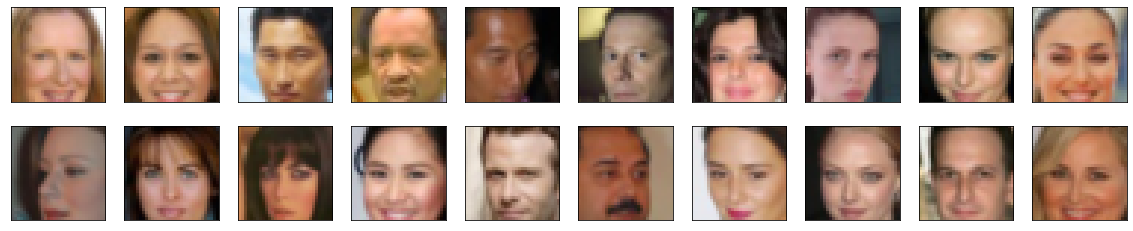

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
     # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x
    

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8039)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    
    elif hasattr(m, 'weight') and classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9 # smooth, real labels = 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
# params
#lr = 0.0002
lr = 0.001
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
def optimizer(lr):
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

    return d_optimizer, g_optimizer

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def save_data(index, losses, batch_size):
    losses = np.array(losses)
    
    # Export Loss as Dataframe
    idx = range(len(losses.T[0]))
    d = {'Discriminator': losses.T[0], 'Generator': losses.T[1]}
    loss_df = pd.DataFrame(data=d, index = idx)
    train_number = train_n + index
    loss_df.to_excel('train_' + str(train_number) +'_'+ param + ".xlsx")
    
    # Export hyperparameters
    hyper_params = {'batch_size': batch_size,
                'img_size': img_size,
                'deconv-layers': 3,
                'conv-layers': 3,
                'd_conv_dim': d_conv_dim,
                'g_conv_dim': g_conv_dim,
                'z_size': z_size,
                'lr': lr,
                'beta1': beta1,
                'beta2': beta2,
                'dropout': 'no',
                'n_epochs': n_epochs
                }
    hyper_param_df = pd.DataFrame.from_dict(hyper_params, orient='index')
    hyper_param_df.to_excel('train_' + str(train_number) +'_'+ param + "_hyper_param.xlsx")
    print(hyper_params)

In [21]:
def plot_training_loss(losses):
    print('Plot Loss')
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(index, epoch=-1):
    print('View Samples')
    train_number = train_n + index
    # Load samples from generator, taken while training
    with open('train_' + str(train_number) +'_'+ param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [23]:
def train(D, G, index, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    train_number = train_n + index
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_' + str(train_number) +'_'+ param + '_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

Epoch [   40/  100] | d_loss: 0.0000 | g_loss: 50.3049
Epoch [   41/  100] | d_loss: 0.0000 | g_loss: 50.3049
Epoch [   41/  100] | d_loss: 0.0000 | g_loss: 50.3049
Epoch [   41/  100] | d_loss: 0.0000 | g_loss: 50.3054
Epoch [   42/  100] | d_loss: 0.0000 | g_loss: 50.3054
Epoch [   42/  100] | d_loss: 0.0000 | g_loss: 50.3053
Epoch [   42/  100] | d_loss: 0.0000 | g_loss: 50.3171
Epoch [   43/  100] | d_loss: 0.0000 | g_loss: 50.3171
Epoch [   43/  100] | d_loss: 0.0000 | g_loss: 50.3170
Epoch [   43/  100] | d_loss: 0.0000 | g_loss: 50.3171
Epoch [   44/  100] | d_loss: 0.0000 | g_loss: 50.3171
Epoch [   44/  100] | d_loss: 0.0000 | g_loss: 50.3172
Epoch [   44/  100] | d_loss: 0.0000 | g_loss: 50.3172
Epoch [   45/  100] | d_loss: 0.0000 | g_loss: 50.3174
Epoch [   45/  100] | d_loss: 0.0000 | g_loss: 50.3174
Epoch [   45/  100] | d_loss: 0.0000 | g_loss: 50.3176
Epoch [   46/  100] | d_loss: 0.0000 | g_loss: 50.3176
Epoch [   46/  100] | d_loss: 0.0000 | g_loss: 50.3176
Epoch [   

Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 52.7190
Epoch [   90/  100] | d_loss: 0.0000 | g_loss: 52.5287
Epoch [   91/  100] | d_loss: 0.0000 | g_loss: 52.7093
Epoch [   91/  100] | d_loss: 0.0000 | g_loss: 52.7924
Epoch [   91/  100] | d_loss: 0.0000 | g_loss: 52.6317
Epoch [   92/  100] | d_loss: 0.0000 | g_loss: 52.6687
Epoch [   92/  100] | d_loss: 0.0000 | g_loss: 53.4270
Epoch [   92/  100] | d_loss: 0.0000 | g_loss: 52.5404
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 53.0027
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 52.9899
Epoch [   93/  100] | d_loss: 0.0000 | g_loss: 53.6125
Epoch [   94/  100] | d_loss: 0.0000 | g_loss: 52.5925
Epoch [   94/  100] | d_loss: 0.0000 | g_loss: 52.7261
Epoch [   94/  100] | d_loss: 0.0000 | g_loss: 52.6289
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 52.6388
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 52.5273
Epoch [   95/  100] | d_loss: 0.0000 | g_loss: 52.5990
Epoch [   96/  100] | d_loss: 0.0000 | g_loss: 52.6749
Epoch [   

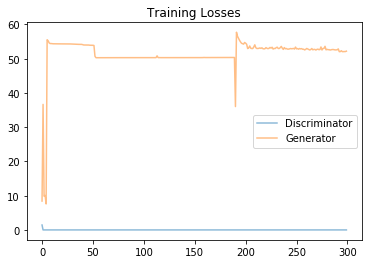

View Samples


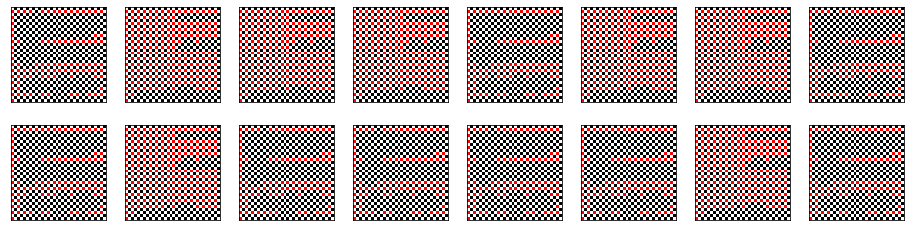

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

Epoch [   41/  100] | d_loss: 0.5814 | g_loss: 2.7691
Epoch [   41/  100] | d_loss: 0.4601 | g_loss: 2.9179
Epoch [   42/  100] | d_loss: 0.2993 | g_loss: 4.7854
Epoch [   42/  100] | d_loss: 0.7815 | g_loss: 5.9585
Epoch [   42/  100] | d_loss: 0.8747 | g_loss: 8.3740
Epoch [   43/  100] | d_loss: 0.6275 | g_loss: 3.2778
Epoch [   43/  100] | d_loss: 0.2718 | g_loss: 5.4043
Epoch [   43/  100] | d_loss: 0.8562 | g_loss: 7.0759
Epoch [   44/  100] | d_loss: 0.3633 | g_loss: 2.8149
Epoch [   44/  100] | d_loss: 0.5902 | g_loss: 5.4050
Epoch [   44/  100] | d_loss: 0.2951 | g_loss: 5.0808
Epoch [   45/  100] | d_loss: 1.2901 | g_loss: 1.1488
Epoch [   45/  100] | d_loss: 0.4489 | g_loss: 3.2986
Epoch [   45/  100] | d_loss: 0.6896 | g_loss: 6.6968
Epoch [   46/  100] | d_loss: 0.5604 | g_loss: 5.1597
Epoch [   46/  100] | d_loss: 0.8212 | g_loss: 8.5980
Epoch [   46/  100] | d_loss: 0.6044 | g_loss: 5.3940
Epoch [   47/  100] | d_loss: 0.4850 | g_loss: 5.2797
Epoch [   47/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.1803 | g_loss: 5.8129
Epoch [   92/  100] | d_loss: 0.1993 | g_loss: 5.1720
Epoch [   92/  100] | d_loss: 1.0558 | g_loss: 14.7569
Epoch [   93/  100] | d_loss: 0.2430 | g_loss: 6.7901
Epoch [   93/  100] | d_loss: 0.1199 | g_loss: 4.8756
Epoch [   93/  100] | d_loss: 0.1825 | g_loss: 4.1394
Epoch [   94/  100] | d_loss: 1.0615 | g_loss: 12.2222
Epoch [   94/  100] | d_loss: 0.2590 | g_loss: 3.5580
Epoch [   94/  100] | d_loss: 0.2720 | g_loss: 8.8932
Epoch [   95/  100] | d_loss: 0.2941 | g_loss: 7.1346
Epoch [   95/  100] | d_loss: 1.4791 | g_loss: 0.6873
Epoch [   95/  100] | d_loss: 0.0645 | g_loss: 7.3817
Epoch [   96/  100] | d_loss: 0.0756 | g_loss: 6.3834
Epoch [   96/  100] | d_loss: 0.2714 | g_loss: 6.7119
Epoch [   96/  100] | d_loss: 0.6742 | g_loss: 2.1010
Epoch [   97/  100] | d_loss: 0.5980 | g_loss: 8.1190
Epoch [   97/  100] | d_loss: 0.1639 | g_loss: 4.8701
Epoch [   97/  100] | d_loss: 0.1187 | g_loss: 7.6540
Epoch [   98/  100] | d_lo

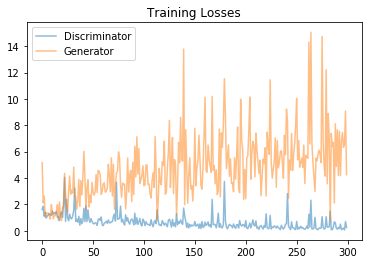

View Samples


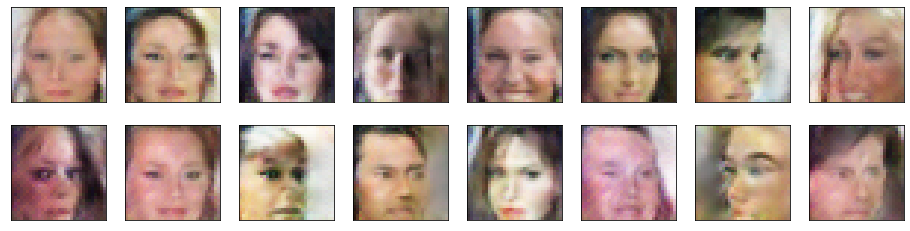

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

Epoch [   41/  100] | d_loss: 0.7510 | g_loss: 2.0992
Epoch [   41/  100] | d_loss: 0.7988 | g_loss: 2.7090
Epoch [   42/  100] | d_loss: 0.6988 | g_loss: 1.6477
Epoch [   42/  100] | d_loss: 0.5788 | g_loss: 1.6928
Epoch [   42/  100] | d_loss: 0.5733 | g_loss: 2.8580
Epoch [   43/  100] | d_loss: 0.4852 | g_loss: 2.1761
Epoch [   43/  100] | d_loss: 0.5596 | g_loss: 2.2077
Epoch [   43/  100] | d_loss: 0.5056 | g_loss: 2.0242
Epoch [   44/  100] | d_loss: 0.5570 | g_loss: 2.3027
Epoch [   44/  100] | d_loss: 0.7496 | g_loss: 1.8862
Epoch [   44/  100] | d_loss: 0.5913 | g_loss: 1.6873
Epoch [   45/  100] | d_loss: 0.6558 | g_loss: 2.4299
Epoch [   45/  100] | d_loss: 0.4819 | g_loss: 1.8409
Epoch [   45/  100] | d_loss: 0.5646 | g_loss: 2.4906
Epoch [   46/  100] | d_loss: 1.0023 | g_loss: 2.9495
Epoch [   46/  100] | d_loss: 0.6012 | g_loss: 1.5699
Epoch [   46/  100] | d_loss: 0.4727 | g_loss: 1.5647
Epoch [   47/  100] | d_loss: 0.6991 | g_loss: 2.6853
Epoch [   47/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.2923 | g_loss: 3.2261
Epoch [   92/  100] | d_loss: 0.2424 | g_loss: 3.2720
Epoch [   92/  100] | d_loss: 0.2169 | g_loss: 2.5467
Epoch [   93/  100] | d_loss: 0.4981 | g_loss: 4.0976
Epoch [   93/  100] | d_loss: 0.2683 | g_loss: 2.9045
Epoch [   93/  100] | d_loss: 0.3553 | g_loss: 2.6106
Epoch [   94/  100] | d_loss: 0.2204 | g_loss: 3.5932
Epoch [   94/  100] | d_loss: 0.4383 | g_loss: 1.6653
Epoch [   94/  100] | d_loss: 0.2502 | g_loss: 2.9233
Epoch [   95/  100] | d_loss: 0.3038 | g_loss: 2.2301
Epoch [   95/  100] | d_loss: 0.3948 | g_loss: 3.4470
Epoch [   95/  100] | d_loss: 0.2110 | g_loss: 3.5419
Epoch [   96/  100] | d_loss: 0.5361 | g_loss: 5.6899
Epoch [   96/  100] | d_loss: 0.5751 | g_loss: 2.5303
Epoch [   96/  100] | d_loss: 0.3404 | g_loss: 1.7771
Epoch [   97/  100] | d_loss: 0.2622 | g_loss: 2.7132
Epoch [   97/  100] | d_loss: 0.1747 | g_loss: 2.8923
Epoch [   97/  100] | d_loss: 0.1584 | g_loss: 2.5584
Epoch [   98/  100] | d_loss

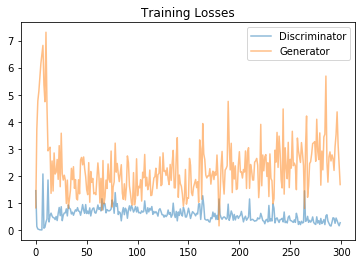

View Samples


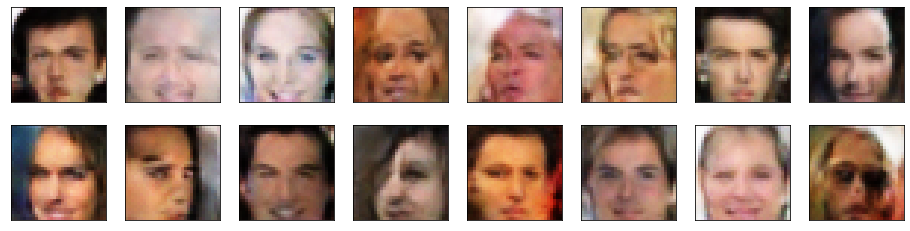

In [24]:
train_n = 21
param = 'lr'

# set parameter sets
number_epochs = [100, 500, 1000]
lr_set = [0.1, 0.01, 0.0001]
batch_size_set = [64, 128, 256, 512]
conv_dim_set = [64, 128, 256]

# default
batch_size = 128
n_epochs = 100
conv_dim = 64
lr = 0.001
beta1=0.5
beta2=0.999
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
#for index, num_epochs in enumerate(number_epochs):
#for index, conv_dim in enumerate(conv_dim_set):
#for index, batch_size in enumerate(batch_size_set):
for index, lr in enumerate(lr_set):
    # Set Parameter
    n_epochs = n_epochs
    lr = lr
    batch_size = batch_size
    d_conv_dim = conv_dim
    g_conv_dim = conv_dim
    
    # Get dataloader
    celeba_train_loader = get_dataloader(batch_size, img_size)
    
    # Build network
    print('Build Network')
    D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
    # Reset optimizer
    d_optimizer, g_optimizer = optimizer(lr)
    
    # Calculate losses
    losses = train(D, G, index, n_epochs=n_epochs)
    
    # Save and Plot Data
    save_data(index, losses, batch_size)
    plot_training_loss(losses)
    _ = view_samples(index, epoch=-1)
    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

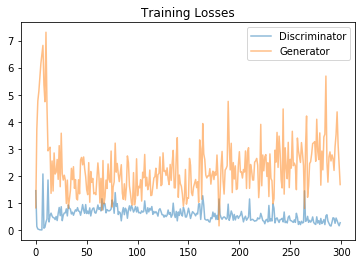

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples_2(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

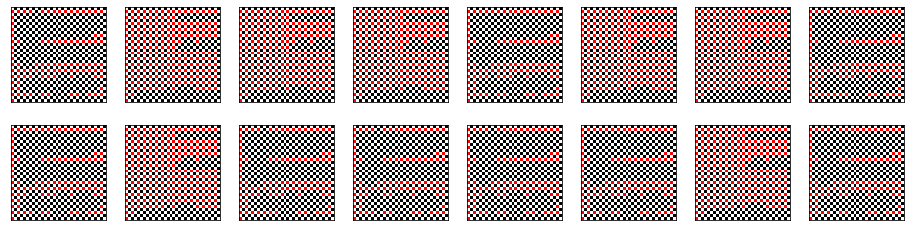

In [32]:
# lr=0.1
with open('train_18_lr_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples)

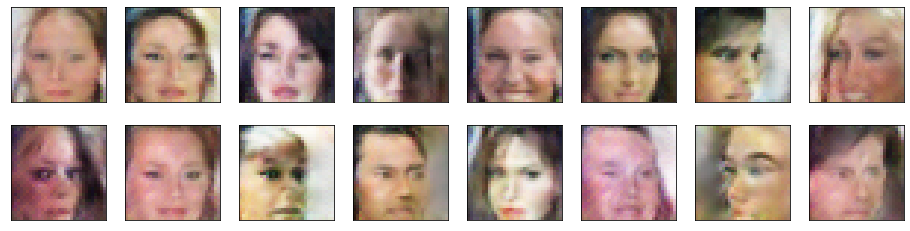

In [33]:
# lr=0.01
with open('train_19_lr_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples)

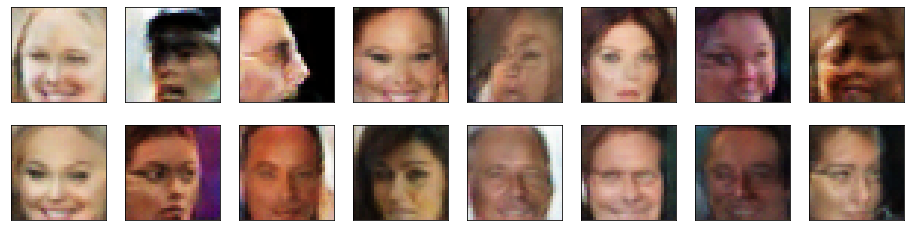

In [42]:
# lr=0.001
with open('train_8_conv_deconv_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples)

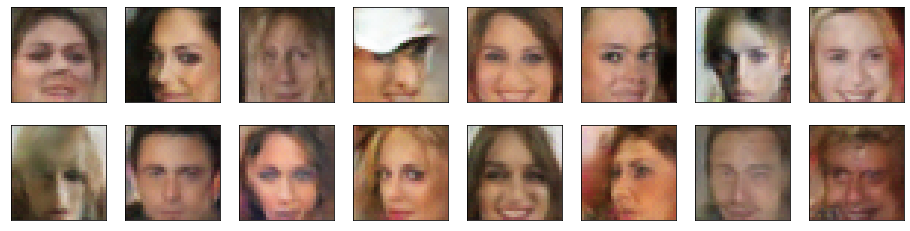

In [41]:
# lr=0.0001
with open('train_20_lr_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.